In [15]:
import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, StratifiedKFold


import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# DOWNLOAD DATASET

In [16]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
origin = pd.read_csv('kindey_stone_urine_analysis.csv')



sample_submission = pd.read_csv('sample_submission.csv')

In [17]:
train.drop(columns='id', inplace=True)

# EDA

In [18]:
train.target.value_counts()

0    230
1    184
Name: target, dtype: int64

In [19]:
df = pd.concat([train, origin], axis=0)

In [20]:
from sklearn.utils import shuffle

In [21]:
df = shuffle(df)

In [22]:
def missing_values(df):
    return pd.DataFrame({
        'feature': df.columns,
        'missing_values': df.isna().sum(),
    }).set_index('feature').sort_values(by='missing_values', ascending=False)

display(missing_values(df).T)

feature,gravity,ph,osmo,cond,urea,calc,target
missing_values,0,0,0,0,0,0,0


# PYCARET

In [23]:
pip install pycaret

In [24]:
from pycaret.classification import *

In [25]:
%time 
setup(data = df, 
      target = 'target')

In [26]:
compare_models(sort='AUC',n_select = 5)

In [27]:
df.describe().T

we can see high std of osmo, urea features.

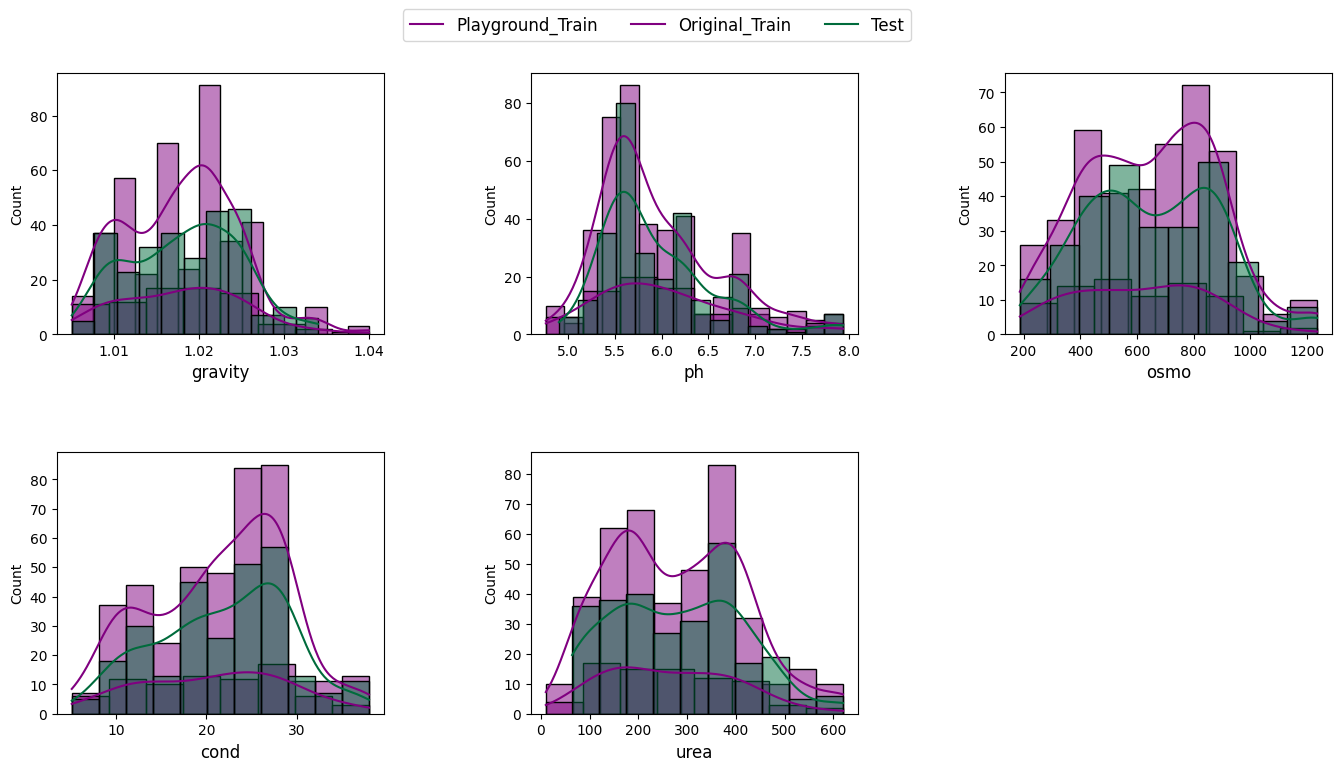

In [53]:
# Create multiple plots with a given size
fig = plt.figure(figsize=(15,12))

features = df.columns[0:-1]

# Create a countplot to evaluate the distribution
for i, feature in enumerate(features):
    ax = plt.subplot(3, 3, i+1)
    sns.histplot(x=feature, data=train, label="Playground_Train", color='#800080', ax=ax, alpha=0.5, kde=True)
    sns.histplot(x=feature, data=origin, label="Playground_Train", color='#800080', ax=ax, alpha=0.5, kde=True)
    sns.histplot(x=feature, data=test, label="Test", color='#006b3c', ax=ax, alpha=0.5, kde=True)
    ax.set_xlabel(feature, fontsize=12)

# Create the legend
fig.legend(labels=['Playground_Train', 'Original_Train', 'Test'], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=12, ncol=3)

# Adjust the spacing between the subplots and the legend
fig.subplots_adjust(top=0.90, bottom=0.05, left=0.10, right=0.95, hspace=0.45, wspace=0.45)

plt.show()

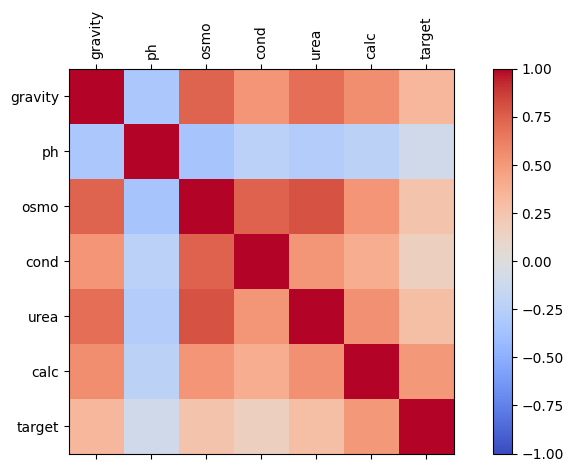

In [29]:
import seaborn as sbs
import matplotlib.pyplot as plt

features = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target']
corr = df[features].corr(method = 'spearman')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(corr.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df[features].columns)
ax.set_yticklabels(df[features].columns)
plt.show()

- Correlatin matrix suggests that "ph" has a negative relationship with target and "osmo" and "gravity" seems to have a positive relationship.
- osmo has high corellation with urea.

In [30]:
(df.corr()['target']*100).sort_values(ascending=False)

target     100.000000
calc        47.868271
gravity     30.564055
urea        26.431949
osmo        24.286116
cond        15.369029
ph          -9.824630
Name: target, dtype: float64

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(df[features].values, i) for i in range(df[features].shape[1])]
vif['variable'] = df[features].columns

vif.sort_values(by='VIF', ascending=False)

# FEATURE ENGINERING 

In [32]:
#def add_features(df):
    #df['osmo_without_urea'] = df['osmo'] - df['urea']   
    #df["gravity/ph"] = df["gravity"] / df["ph"]
    #df["osmo/cond"] = df["osmo"] / df["cond"]
    #df["gravity*ph"] = df["gravity"] * df["ph"]
    #df["gravity*osmo"] = df["gravity"] * df["osmo"]
    #df["osmo*urea"] = df["osmo"] * df["urea"]
    #df["cond_urea_ph"] = df["cond"] * df["urea"] / df["ph"]
    #df["ph*osmo"] = df["ph"] * df["osmo"]
    #df["cond*calc"] = df["cond"] * df["calc"]
    #df["gravity/calc"] = df["gravity"] / df["calc"]

    #return df

#df = add_features(df)

In [33]:
df.describe().T

In [34]:
# encode the target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(df['target'])

Y = pd.Series(data = le.transform(df['target']))

# BASELINE MODEL

In [35]:
classifiers = [
    ('Random Forest', RandomForestClassifier(n_estimators=150, random_state=42)),
    ('LR', LogisticRegression(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=3, random_state=42)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('lightgbm', LGBMClassifier(random_state=42))
]

X = df.drop(["target"], axis =1)


for name, classifier in classifiers:
    clf = classifier
    # Perform cross-validation with 10-folds
    cv_scores = cross_val_score(clf, X, Y, cv=10, scoring='roc_auc') 
    # Print the cross-validation scores
    print(f"Average cross-validation score for {name}:", np.mean(cv_scores))
    print(f"Std cross-validation score for {name}:", np.std(cv_scores))
    print("-"*20)

Average cross-validation score for Random Forest: 0.8142238713667286
Std cross-validation score for Random Forest: 0.08007843447144536
--------------------
Average cross-validation score for LR: 0.7839113928399642
Std cross-validation score for LR: 0.09752264579828866
--------------------
Average cross-validation score for Gradient Boosting: 0.8006905792620078
Std cross-validation score for Gradient Boosting: 0.06896680890775735
--------------------
Average cross-validation score for XGBoost: 0.8013304816876244
Std cross-validation score for XGBoost: 0.07031790338681167
--------------------
Average cross-validation score for lightgbm: 0.802665258022401
Std cross-validation score for lightgbm: 0.07808428162725065
--------------------


# OPTUNA

In [38]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.5 MB/s eta 0:00:00


In [39]:
import optuna

In [40]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 100)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    classifier = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, 
                                         min_samples_split=min_samples_split, 
                                         min_samples_leaf=min_samples_leaf, 
                                         n_jobs=2)
    
    #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    score = cross_val_score(classifier, X, Y, cv=5, scoring="roc_auc")
    
    mean_score = score.mean()
    
    return mean_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=50) # temps de la recherche 600 secondes, soit 10 minutes

model = RandomForestClassifier(max_depth=study.best_params['max_depth'], 
                               n_estimators=study.best_params['n_estimators'], 
                               min_samples_split=study.best_params['min_samples_split'], 
                               min_samples_leaf=study.best_params['min_samples_leaf'], 
                               n_jobs=2)

model.fit(X, Y)

[I 2023-04-17 10:21:48,649] A new study created in memory with name: no-name-2d5d28dc-8cb9-4e9e-a222-6cb77a2148b8
[I 2023-04-17 10:22:00,397] Trial 0 finished with value: 0.8206640399769365 and parameters: {'max_depth': 86, 'n_estimators': 445, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8206640399769365.
[I 2023-04-17 10:22:11,150] Trial 1 finished with value: 0.8189015952335191 and parameters: {'max_depth': 31, 'n_estimators': 447, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8206640399769365.
[I 2023-04-17 10:22:11,887] Trial 2 finished with value: 0.8066644243705554 and parameters: {'max_depth': 8, 'n_estimators': 23, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8206640399769365.
[I 2023-04-17 10:22:13,947] Trial 3 finished with value: 0.813612339035172 and parameters: {'max_depth': 20, 'n_estimators': 91, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 0 with value: 0

RandomForestClassifier(max_depth=86, min_samples_leaf=4, min_samples_split=6,
                       n_estimators=445, n_jobs=2)

In [41]:
test.drop(columns='id', inplace=True)

In [42]:
pred = model.predict_proba(test)[:,1]

submission= pd.DataFrame({
    'id' : sample_submission['id'],
    'target' : pred
})

submission.to_csv('submission.csv', index= False)
pd.read_csv('submission.csv', index_col=0)

,target
id,
414,0.265805
415,0.500075
416,0.890898
417,0.396942
418,0.322345
...,...
685,0.805966
686,0.084962
687,0.672809


# Приложение streamlit

In [43]:
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 10.0 MB/s eta 0:00:00


In [45]:
import joblib

joblib_file = "model.pkl" 
joblib.dump(model, joblib_file)
model = joblib.load("model.pkl")

In [46]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


  command:

    streamlit run /usr/local/lib/python3.9/dist-packages/ipykernel_launcher.py [ARGUMENTS]
2023-04-17 10:25:00.106 
  command:

    streamlit run /usr/local/lib/python3.9/dist-packages/ipykernel_launcher.py [ARGUMENTS]


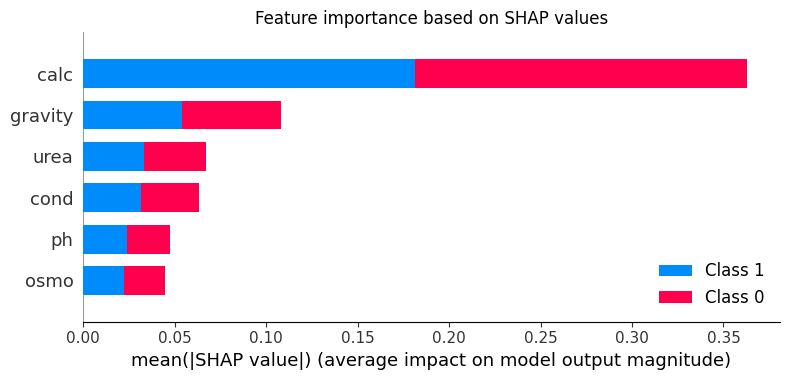

<Figure size 640x480 with 0 Axes>

In [49]:
import joblib
import streamlit as st
import pandas as pd
import base64
import pickle
from PIL import Image
from urllib.request import urlopen
import shap

image = Image.open(urlopen('https://f.stolichki.ru/s/media/articles/131b46e7ed0d3f49207a796922803e59.jpg'))

st.title('# Kidney Stone Prediction based on Urine Analysis')

st.image(image, use_column_width=True)

st.markdown("""
      The six physical characteristics of the urine are: (1) specific gravity, the density of the urine relative to water; (2) pH, the negative logarithm of the hydrogen ion; (3) osmolarity (mOsm), a unit used in biology and medicine but not in
      physical chemistry. Osmolarity is proportional to the concentration of
      molecules in solution; (4) conductivity (mMho milliMho). One Mho is one
      reciprocal Ohm. Conductivity is proportional to the concentration of charged
      ions in solution; (5) urea concentration in millimoles per litre; and (6) calcium
      concentration (CALC) in millimolesllitre.
      The data is obtained from 'Physical Characteristics of Urines With and Without Crystals',a chapter from Springer Series in Statistics.
      ***
""")


st.sidebar.header("Specify input parameters")

def user_input_features():
  GRAVITY = st.sidebar.slider('GRAVITY', float(X.gravity.min()), float(X.gravity.max()), float(X.gravity.mean()))
  PH = st.sidebar.slider('PH', float(X.ph.min()), float(X.ph.max()), float(X.ph.mean()))
  OSMO = st.sidebar.slider('OSMO', float(X.osmo.min()), float(X.osmo.max()), float(X.osmo.mean()))
  COND = st.sidebar.slider('COND', float(X.cond.min()), float(X.cond.max()), float(X.cond.mean()))
  UREA = st.sidebar.slider('UREA', float(X.urea.min()), float(X.urea.max()), float(X.urea.mean()))
  CALC = st.sidebar.slider('CALC', float(X.calc.min()), float(X.calc.max()), float(X.calc.mean()))

  data = {'gravity': GRAVITY,
          'ph': PH,
          'osmo': OSMO,
          'cond': COND, 
          'urea': UREA,
          'calc': CALC}

  features = pd.DataFrame(data, index=[0])
  return features

df = user_input_features()

# add new features 
#df = add_features(df)


st.header('Specified input parameters')
st.write(df)
st.write('---')

model = joblib.load("model.pkl")

prediction = model.predict(df)


st.header('Prediction of Kidney Stone')
st.write(prediction)
if prediction == 0:
  st.write("You don't have kidney stones")
else:
  st.write("You have kidney stones. See a doctor")

st.write('---')


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

st.header('Feature Importance')
plt.title('Feature importance based on SHAP values')
shap.summary_plot(shap_values, X)
st.pyplot(bbox_inches='tight')
st.write('---')





In [50]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 2.231s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [51]:
!streamlit run /content/streamlit_app.py &>/content/logs.txt &

In [52]:
!npx localtunnel --port 8501

npx: installed 22 in 1.549s
your url is: https://metal-days-camp-34-132-38-176.loca.lt
^C
